In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    accuracy_score, f1_score, roc_auc_score
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier



In [2]:
offense_players = pd.read_csv("../data/processed/offense_players_salary_only.csv")
print(offense_players.shape)
offense_players.head(3)


(2895, 667)


,player_id,player_name,position,birth_year,draft_year,draft_round,draft_pick,draft_ovr,height,weight,...,delta_ypc,delta_td_pct,delta_yptouch,player_name_clean_x,team_name_readable,cap_hit,cap_percent,team_y,player_name_clean_y,team_abbr
0,00-0007091,Matt Hasselbeck,QB,1975,1998.0,6.0,34.0,187.0,76.0,235.0,...,-1.354756,0.0,0.116000,MATT HASSELBECK,Colts,3750000.0,2.81,indianapolis-colts,MATT HASSELBECK,IND
1,00-0010346,Peyton Manning,QB,1976,1998.0,1.0,1.0,1.0,77.0,230.0,...,0.000000,0.0,-0.181818,PEYTON MANNING,Broncos,17500000.0,12.96,denver-broncos,PEYTON MANNING,DEN
2,00-0010346,Peyton Manning,QB,1976,1998.0,1.0,1.0,1.0,77.0,230.0,...,-1.226244,2.0,0.690632,PEYTON MANNING,Broncos,17500000.0,12.96,denver-broncos,PEYTON MANNING,DEN


In [3]:
defense_players = pd.read_csv("../data/processed/defense_players_salary_only.csv")
defense_players.head(3)

,player_id,player_name_x,position_x,birth_year,draft_year,draft_round,draft_pick,draft_ovr,height,weight,...,delta_season_average_team_defense_snaps,delta_career_average_team_defense_snaps,player_name_clean,team_name_readable,player_name_y,position_y,cap_hit,cap_percent,team_y,team_abbr
0,00-0020515,Ryan Pickett,DT,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.184206,0.0,RYAN PICKETT,Texans,Ryan Pickett,DT,469412.0,0.35,houston-texans,HOU
1,00-0020535,Justin Smith,DE,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.022571,0.0,JUSTIN SMITH,49ers,Justin Smith,DE,6936666.0,5.12,san-francisco-49ers,SF
2,00-0020712,James Harrison,OLB,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.478523,0.0,JAMES HARRISON,Steelers,James Harrison,OLB,534412.0,0.40,pittsburgh-steelers,PIT


In [4]:
print("=== OFFENSE SHAPE ===")
print(offense_players.shape)
print("\n=== OFFENSE COLUMNS ===")
for c in offense_players.columns:
    print(c)

print("\n\n=== DEFENSE SHAPE ===")
print(defense_players.shape)
print("\n=== DEFENSE COLUMNS ===")
for c in defense_players.columns:
    print(c)

=== OFFENSE SHAPE ===
(2895, 667)

=== OFFENSE COLUMNS ===
player_id
player_name
position
birth_year
draft_year
draft_round
draft_pick
draft_ovr
height
weight
college
season
season_type
team_x
conference
division
shotgun
no_huddle
qb_dropback
qb_scramble
pass_attempts
complete_pass
incomplete_pass
passing_yards
receiving_yards
yards_after_catch
rush_attempts
rushing_yards
tackled_for_loss
first_down_pass
first_down_rush
third_down_converted
third_down_failed
fourth_down_converted
fourth_down_failed
rush_touchdown
pass_touchdown
safety
interception
fumble
fumble_lost
fumble_forced
fumble_not_forced
fumble_out_of_bounds
receptions
targets
passing_air_yards
receiving_air_yards
receiving_touchdown
pass_attempts_redzone
complete_pass_redzone
pass_touchdown_redzone
pass_attempts_gtg
complete_pass_gtg
pass_touchdown_gtg
receptions_redzone
targets_redzone
receiving_touchdown_redzone
receptions_gtg
targets_gtg
receiving_touchdown_gtg
rush_attempts_redzone
rush_touchdown_redzone
rush_attempts_gt

In [5]:
# ============================================================
# CLEAN OFFENSE & DEFENSE PLAYER DATA (Removal of career_ and delta_)
# ============================================================

def clean_player_dataset(df):
    df_clean = df.copy()

    # Columns to remove:
    cols_to_drop = [
        c for c in df_clean.columns
        if c.startswith("career_")            # career stats
        or "delta" in c.lower()               # delta / change stats
        or "fantasy" in c.lower()             # fantasy-derived stats
        or "grade" in c.lower()               # PFF grades, etc.
        or "rank" in c.lower()                # rankings / advanced leaking
    ]

    print(f"Removing {len(cols_to_drop)} derived/career columns:")
    for c in cols_to_drop:
        print(" -", c)

    df_clean = df_clean.drop(columns=cols_to_drop, errors="ignore")
    return df_clean


# Apply to offensive and defensive players
offense_clean = clean_player_dataset(offense_players)
defense_clean = clean_player_dataset(defense_players)

print("\n=== CLEANED OFFENSE SHAPE ===", offense_clean.shape)
print("\n=== OFFENSE COLUMNS ===")
for c in offense_clean.columns:
    print(c)
print("=== CLEANED DEFENSE SHAPE ===", defense_clean.shape)
print("\n=== DEFENSE COLUMNS ===")
for c in defense_clean.columns:
    print(c)

Removing 432 derived/career columns:
 - fantasy_points_ppr
 - fantasy_points_standard
 - season_fantasy_points_ppr
 - season_fantasy_points_standard
 - career_shotgun
 - career_no_huddle
 - career_qb_dropback
 - career_qb_scramble
 - career_pass_attempts
 - career_complete_pass
 - career_incomplete_pass
 - career_passing_yards
 - career_receiving_yards
 - career_yards_after_catch
 - career_rush_attempts
 - career_rushing_yards
 - career_tackled_for_loss
 - career_first_down_pass
 - career_first_down_rush
 - career_third_down_converted
 - career_third_down_failed
 - career_fourth_down_converted
 - career_fourth_down_failed
 - career_rush_touchdown
 - career_pass_touchdown
 - career_safety
 - career_interception
 - career_fumble
 - career_fumble_lost
 - career_fumble_forced
 - career_fumble_not_forced
 - career_fumble_out_of_bounds
 - career_receptions
 - career_targets
 - career_passing_air_yards
 - career_receiving_air_yards
 - career_receiving_touchdown
 - career_pass_attempts_redzone

In [6]:
# Remove cap_hit (keep cap_percent)
if "cap_hit" in offense_clean.columns:
    offense_clean = offense_clean.drop(columns=["cap_hit","games_played_career"])
print("cap_hit removed. Current shape:", offense_clean.shape)


cap_hit removed. Current shape: (2895, 233)


In [7]:
# ============================================================
# REMOVE matched season_* columns & KEEP unmatched (AFTER previous cleaning)
# ============================================================

df = offense_clean.copy()

# Identify all season_* columns except season_average_ (already removed earlier)
season_cols = [
    c for c in df.columns
    if c.startswith("season_") and not c.startswith("season_average_")
]

matched = []
unmatched = []

for col in season_cols:
    base = col.replace("season_", "")
    if base in df.columns:      # base stat exists -> redundant duplicate
        matched.append((col, base))
    else:
        unmatched.append(col)   # no base stat -> keep

print("Matched season_* columns (WILL REMOVE):", len(matched))
for c, b in matched[:25]:
    print(f"  {c}  <->  {b}")

print("\nUnmatched season_* columns (WILL KEEP):", len(unmatched))
for c in unmatched:
    print("  ", c)

# Remove ONLY the matched season_* columns
cols_to_remove = [m[0] for m in matched]
offense_clean = df.drop(columns=cols_to_remove, errors="ignore")

print("\nUpdated offense_clean shape:", offense_clean.shape)


Matched season_* columns (WILL REMOVE): 64
  season_shotgun  <->  shotgun
  season_no_huddle  <->  no_huddle
  season_qb_dropback  <->  qb_dropback
  season_qb_scramble  <->  qb_scramble
  season_pass_attempts  <->  pass_attempts
  season_complete_pass  <->  complete_pass
  season_incomplete_pass  <->  incomplete_pass
  season_passing_yards  <->  passing_yards
  season_receiving_yards  <->  receiving_yards
  season_yards_after_catch  <->  yards_after_catch
  season_rush_attempts  <->  rush_attempts
  season_rushing_yards  <->  rushing_yards
  season_tackled_for_loss  <->  tackled_for_loss
  season_first_down_pass  <->  first_down_pass
  season_first_down_rush  <->  first_down_rush
  season_third_down_converted  <->  third_down_converted
  season_third_down_failed  <->  third_down_failed
  season_fourth_down_converted  <->  fourth_down_converted
  season_fourth_down_failed  <->  fourth_down_failed
  season_rush_touchdown  <->  rush_touchdown
  season_pass_touchdown  <->  pass_touchdown


In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")


In [9]:
# Split offense_clean by position
QB_df = offense_clean[offense_clean["position"] == "QB"].copy()
RB_df = offense_clean[offense_clean["position"] == "RB"].copy()
WR_df = offense_clean[offense_clean["position"] == "WR"].copy()

print("QB_df:", QB_df.shape)
print("RB_df:", RB_df.shape)
print("WR_df:", WR_df.shape)


QB_df: (432, 169)
RB_df: (674, 169)
WR_df: (1071, 169)


In [10]:
def build_feature_target(df, target_col, extra_drop=None):
    """
    Build cleaned feature matrix X and target y for modeling.
    Removes:
      - identifier columns
      - *_next columns (except the target)
      - non-numeric columns
      - rows missing the target
    Fills predictors' NaNs with 0.
    """

    # 1. Columns to drop (ID, text, positions, etc.)
    drop_cols = [
        "player_id", "player_name_x", "player_name_y", "player_name_clean",
        "team", "team_name", "conference", "division",
        "position", "pos",
        "season_type"
    ]

    if extra_drop:
        drop_cols.extend(extra_drop)

    # 2. Drop ALL unwanted columns
    drop_cols = [c for c in drop_cols if c in df.columns]
    df_model = df.drop(columns=drop_cols, errors="ignore")

    # 3. Remove ALL *_next predictor leakage columns EXCEPT the target itself
    next_cols = [c for c in df_model.columns if c.endswith("_next") and c != target_col]
    df_model = df_model.drop(columns=next_cols, errors="ignore")

    # 4. Keep only numeric columns
    num_df = df_model.select_dtypes(include=[np.number])

    # Ensure target exists
    if target_col not in num_df.columns:
        raise ValueError(f"Target {target_col} missing or non-numeric.")

    # Separate features and target
    X = num_df.drop(columns=[target_col])
    y = num_df[target_col]

    # 5. Drop rows missing target
    y_mask = y.notna()
    X = X.loc[y_mask]
    y = y.loc[y_mask]

    # 6. Fill missing predictors with 0
    X = X.fillna(0)

    return X, y


In [11]:
def run_regression_models(X, y, title=""):
    """
    Train multiple regression models:
      - Linear Regression (scaled)
      - Ridge Regression (scaled)
      - RandomForest Regressor
      - GradientBoosting Regressor

    Produces:
      - Metrics table (R2, RMSE, MAE)
      - R² comparison bar chart
      - Linear regression coefficient importance plot
      - Ridge regression coefficient importance plot
      - RandomForest feature importance plot
      - GradientBoosting feature importance plot
      - Predicted vs actual scatter plot (RF)
    """

    # ---------------------------
    # 1. Train-test split
    # ---------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # ---------------------------
    # 2. Models
    # ---------------------------
    models = {
        "LinearRegression": Pipeline([
            ("scaler", StandardScaler()),
            ("lr", LinearRegression())
        ]),

        "Ridge": Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=1.0))
        ]),

        "RandomForest": RandomForestRegressor(
            n_estimators=300, random_state=42, n_jobs=-1
        ),

        "GradientBoosting": GradientBoostingRegressor(
            random_state=42
        )
    }

    results = {}
    rf_info = None

    # ---------------------------
    # 3. Train + evaluate models
    # ---------------------------
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        r2 = r2_score(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)

        results[name] = {
            "R2": r2,
            "RMSE": rmse,
            "MAE": mae
        }

        if name == "RandomForest":
            rf_info = (y_test, preds)

    results_df = pd.DataFrame(results).T

    # ---------------------------
    # 4. Show metrics
    # ---------------------------
    print(f"\n=== Regression Results: {title} ===")
    display(results_df)

    # ---------------------------
    # 5. R² bar chart
    # ---------------------------
    plt.figure(figsize=(6, 4))
    results_df["R2"].plot(kind="bar", color="skyblue")
    plt.ylabel("R²")
    plt.title(f"Model R² Comparison – {title}")
    plt.tight_layout()
    plt.show()

    # ============================================================
    # FEATURE IMPORTANCE / COEFFICIENT PLOTS
    # ============================================================

    # ------------------------------------------
    # 6. Linear Regression Coefficient Importance
    # ------------------------------------------
    try:
        lr_coef = models["LinearRegression"].named_steps["lr"].coef_
        coef_df = pd.Series(lr_coef, index=X.columns).sort_values()

        plt.figure(figsize=(8, 10))
        coef_df.tail(20).plot(kind="barh", color="purple")
        plt.title(f"Linear Regression Coefficient Importance – {title}")
        plt.xlabel("Standardized Coefficient")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("LinearRegression coefficients unavailable:", e)

    # ------------------------------------------
    # 7. Ridge Regression Coefficient Importance
    # ------------------------------------------
    try:
        ridge_coef = models["Ridge"].named_steps["ridge"].coef_
        ridge_df = pd.Series(ridge_coef, index=X.columns).sort_values()

        plt.figure(figsize=(8, 10))
        ridge_df.tail(20).plot(kind="barh", color="teal")
        plt.title(f"Ridge Regression Coefficient Importance – {title}")
        plt.xlabel("Standardized Coefficient")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Ridge coefficients unavailable:", e)

    # ------------------------------------------
    # 8. RandomForest Feature Importance
    # ------------------------------------------
    rf_model = models["RandomForest"]
    rf_model.fit(X_train, y_train)
    importances = rf_model.feature_importances_
    idx = np.argsort(importances)[-20:]

    plt.figure(figsize=(8, 10))
    plt.barh(X.columns[idx], importances[idx], color='green')
    plt.title(f"RandomForest Feature Importance – {title}")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------
    # 9. GradientBoosting Feature Importance
    # ------------------------------------------
    gb_model = models["GradientBoosting"]
    gb_model.fit(X_train, y_train)
    gb_imp = gb_model.feature_importances_
    idx_gb = np.argsort(gb_imp)[-20:]

    plt.figure(figsize=(8, 10))
    plt.barh(X.columns[idx_gb], gb_imp[idx_gb], color='orange')
    plt.title(f"GradientBoosting Feature Importance – {title}")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------
    # 10. Predicted vs Actual (RandomForest)
    # ------------------------------------------
    if rf_info is not None:
        y_test_plot, preds_plot = rf_info

        plt.figure(figsize=(5, 5))
        plt.scatter(y_test_plot, preds_plot, alpha=0.6)
        lims = [
            min(y_test_plot.min(), preds_plot.min()),
            max(y_test_plot.max(), preds_plot.max())
        ]
        plt.plot(lims, lims, "r--")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"RandomForest – Predicted vs Actual – {title}")
        plt.tight_layout()
        plt.show()

    return results_df, rf_info



QB: 432 players with salary data


SALARY MODELS – QB

=== Regression Results: QB Salary (cap_percent) ===


,R2,RMSE,MAE
LinearRegression,-1.297310,6.994667,4.275874
Ridge,0.292895,3.880602,3.083620
RandomForest,0.734142,2.379478,1.566467
GradientBoosting,0.713922,2.468309,1.572505


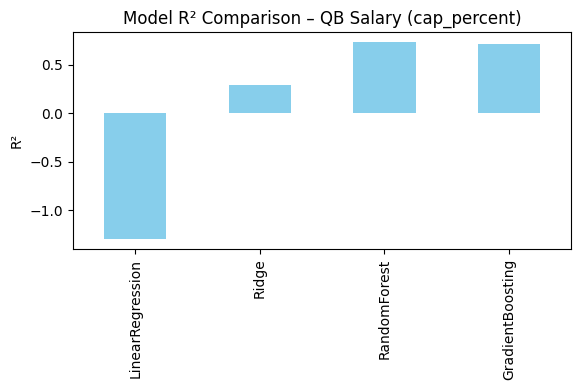

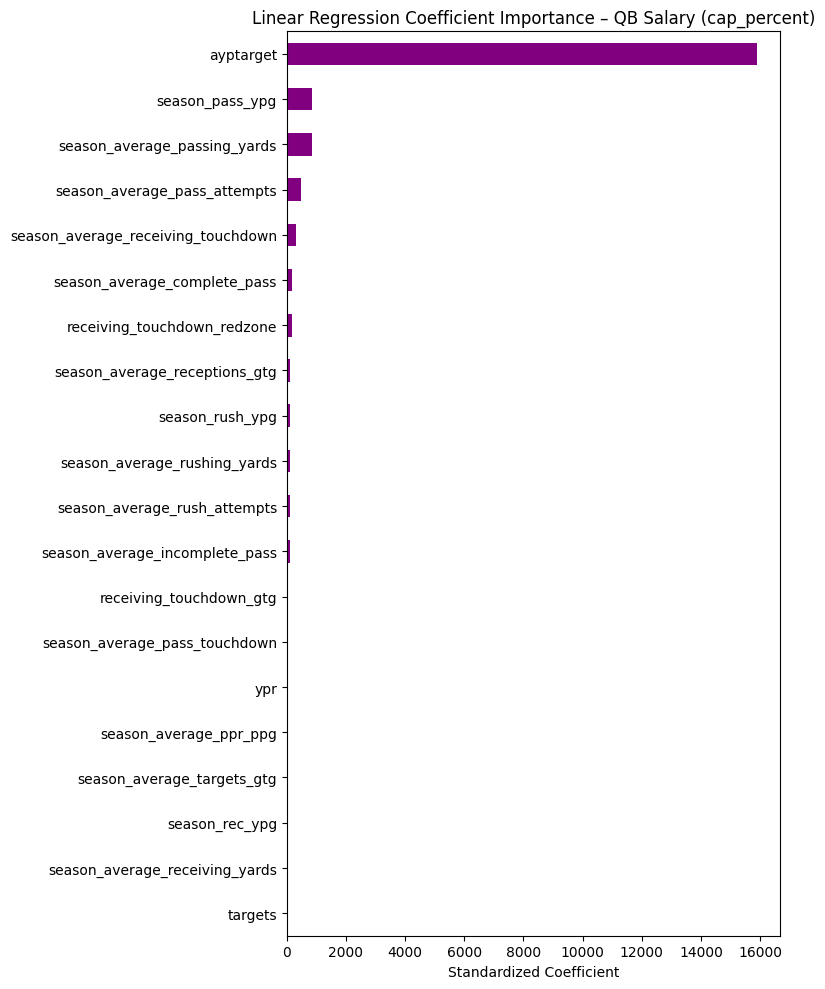

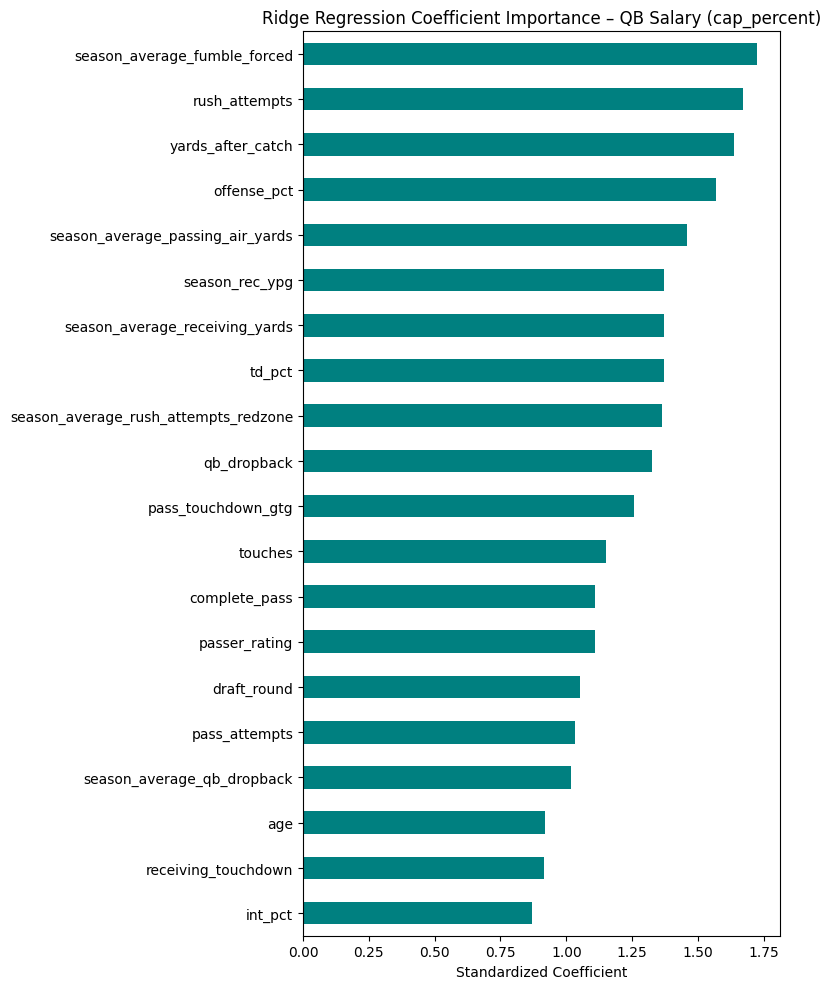

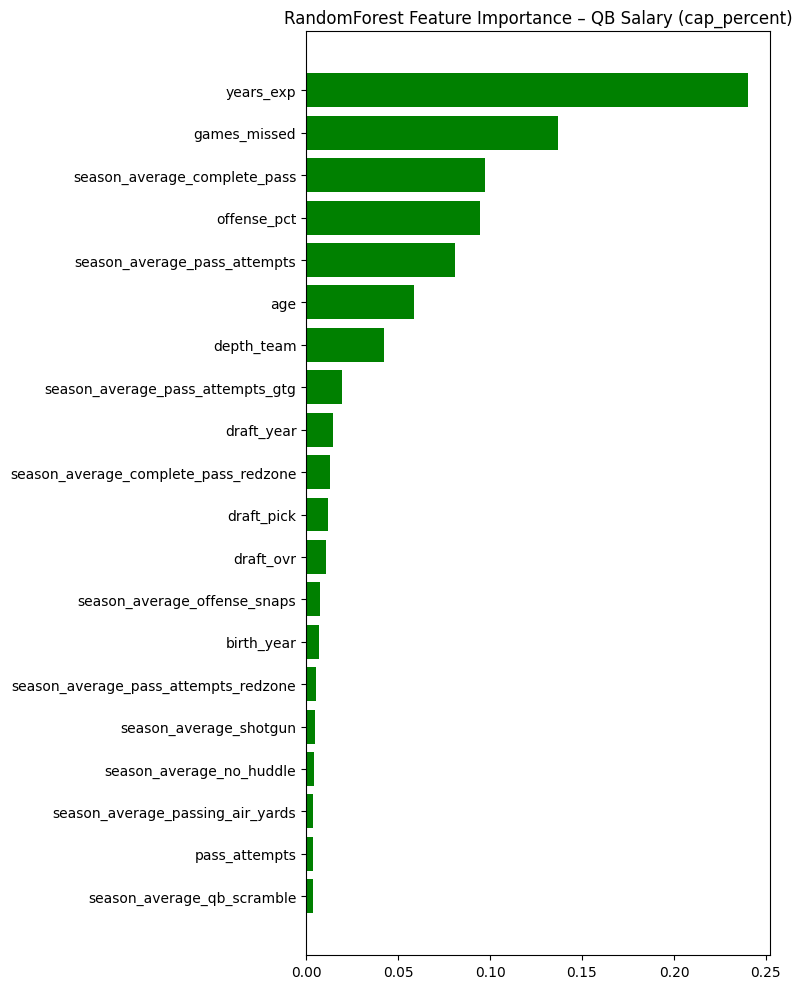

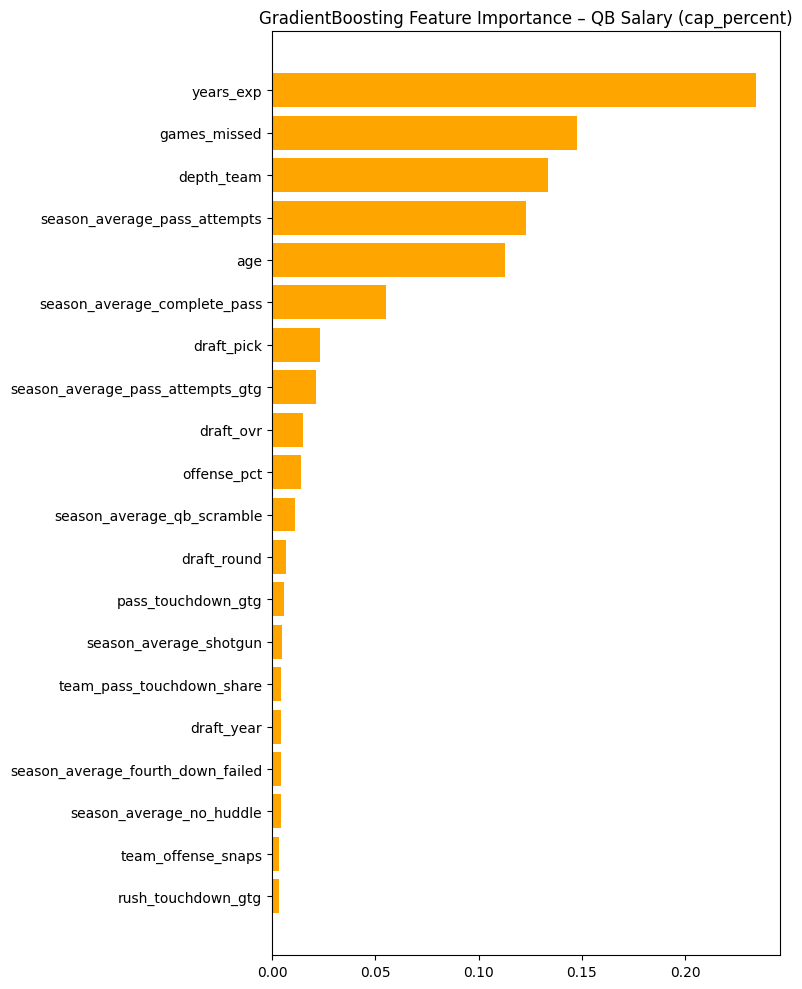

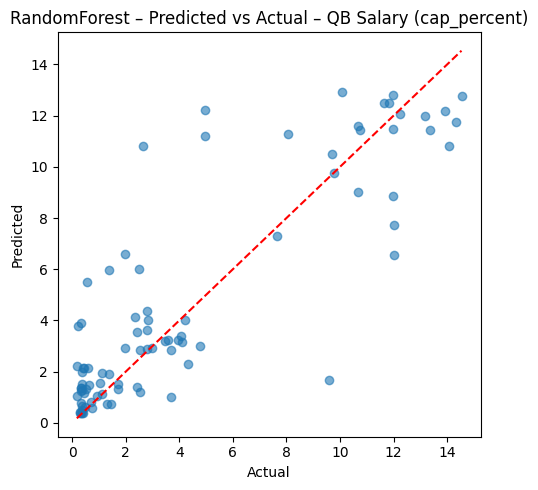

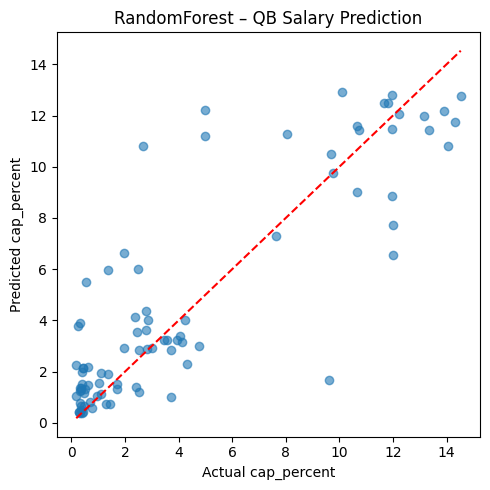


RB: 674 players with salary data


SALARY MODELS – RB

=== Regression Results: RB Salary (cap_percent) ===


,R2,RMSE,MAE
LinearRegression,-1.413380e+09,56369.861031,5342.303925
Ridge,3.085781e-01,1.246778,0.777676
RandomForest,6.205763e-01,0.923591,0.464674
GradientBoosting,6.290863e-01,0.913175,0.485299


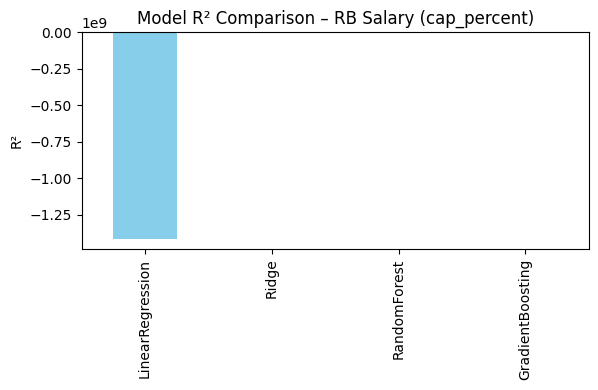

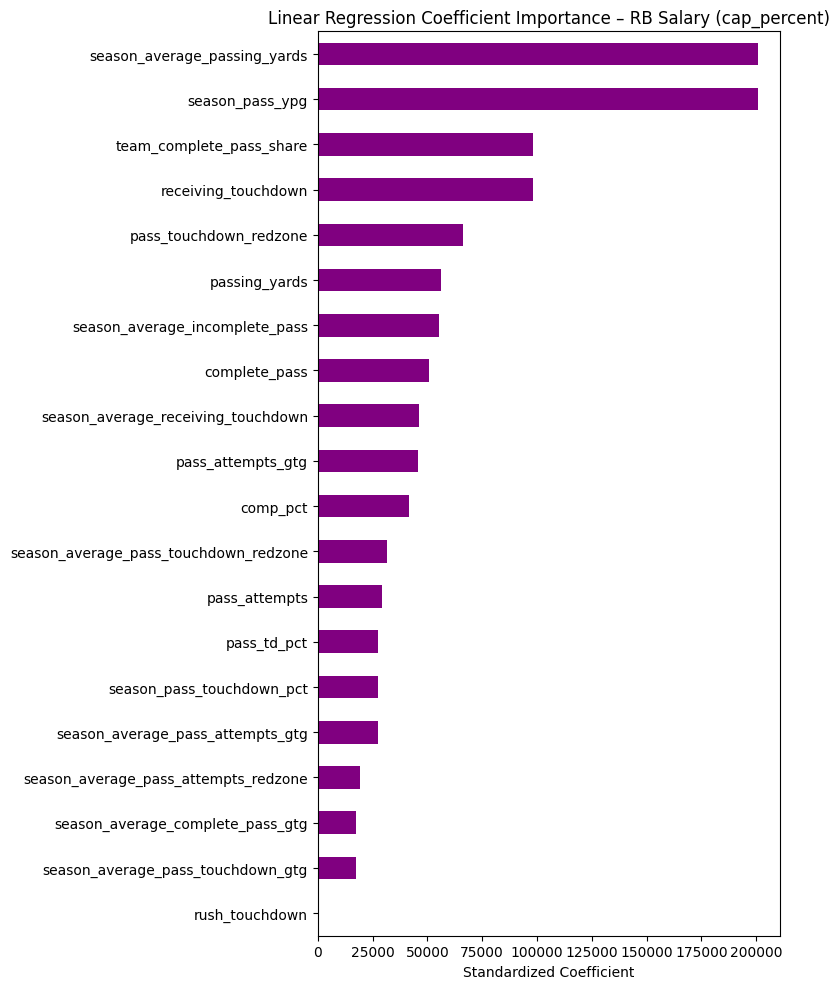

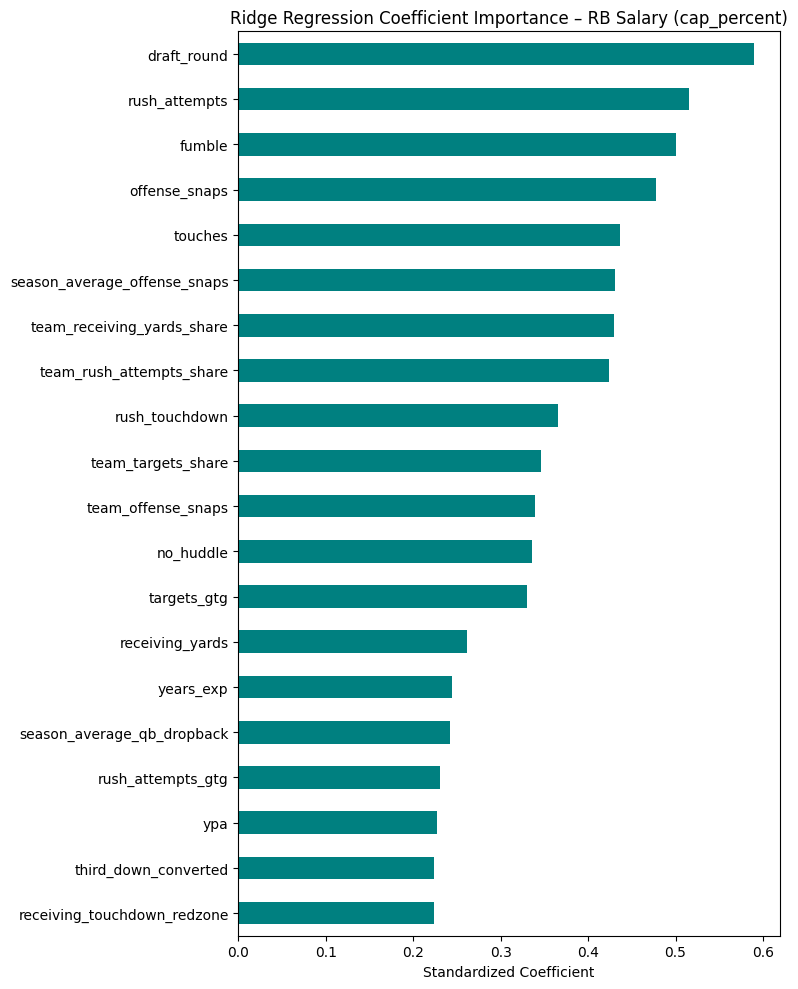

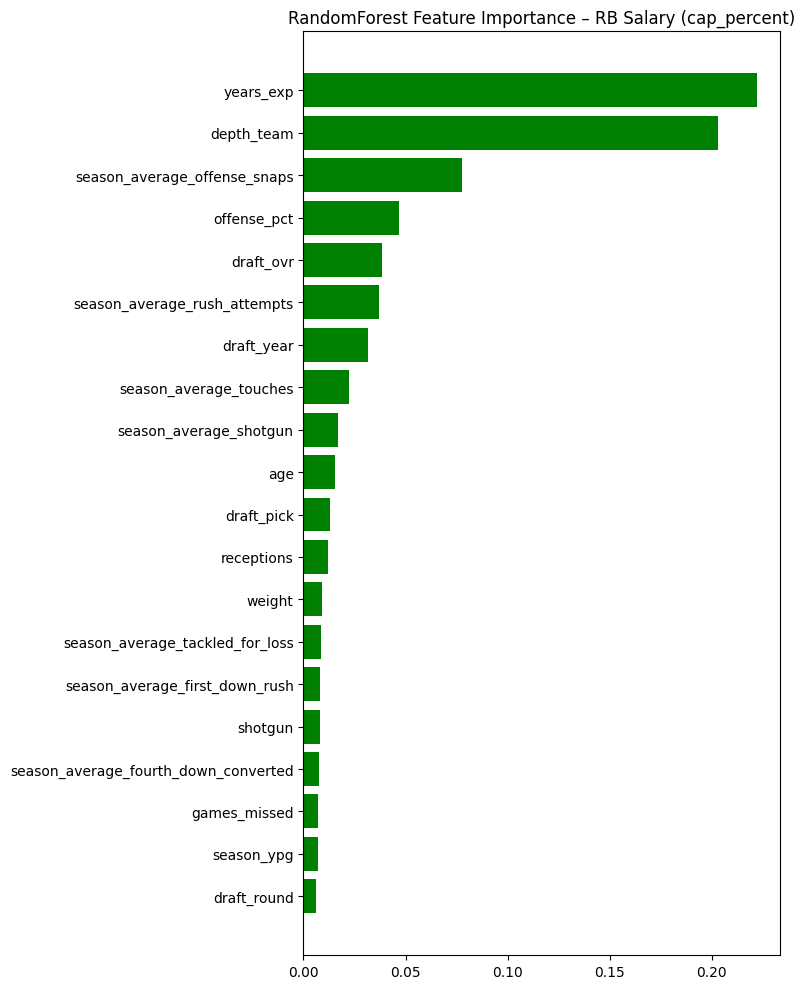

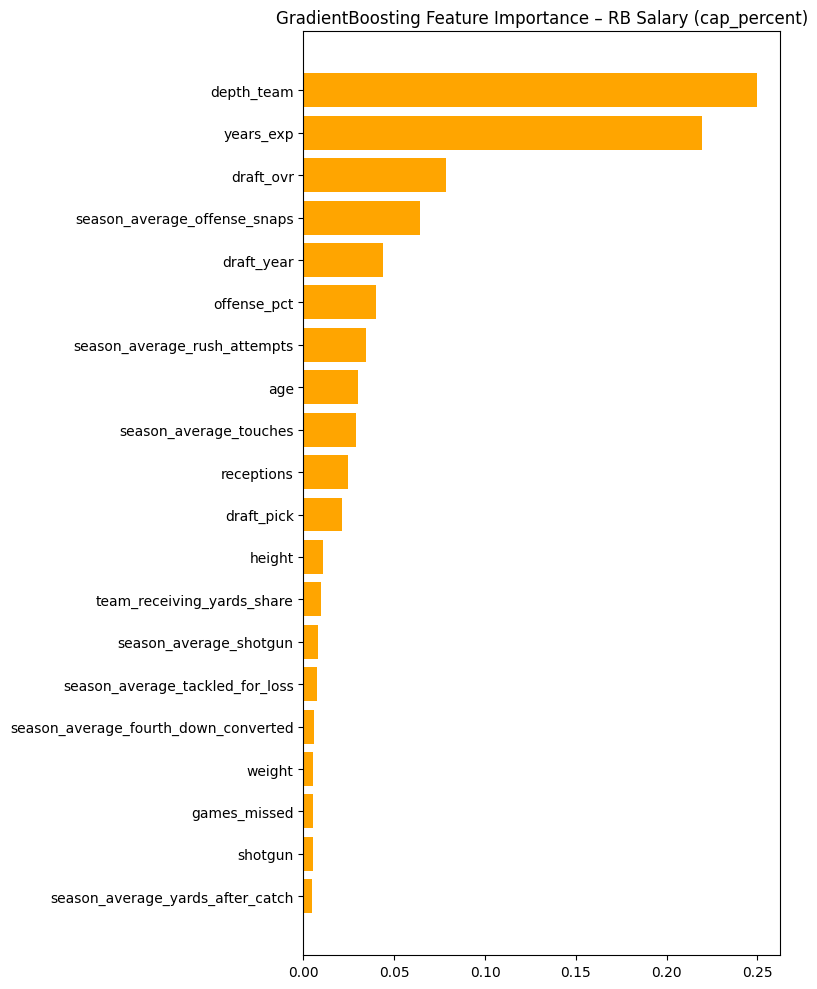

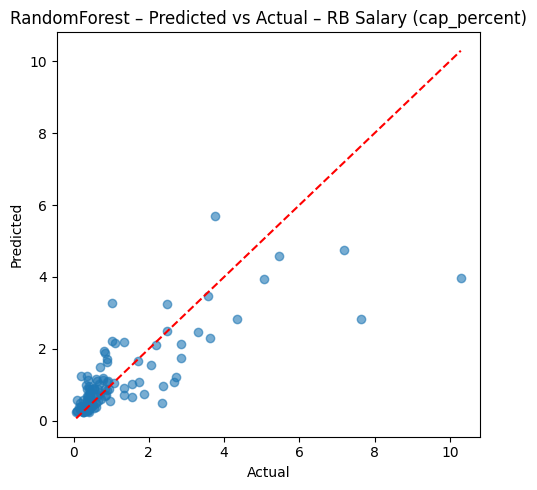

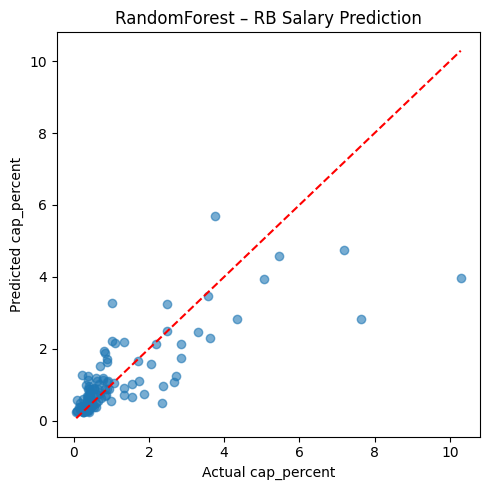


WR: 1071 players with salary data


SALARY MODELS – WR

=== Regression Results: WR Salary (cap_percent) ===


,R2,RMSE,MAE
LinearRegression,0.290520,1.748743,1.250733
Ridge,0.349767,1.674135,1.204110
RandomForest,0.661584,1.207761,0.741376
GradientBoosting,0.698308,1.140349,0.722786


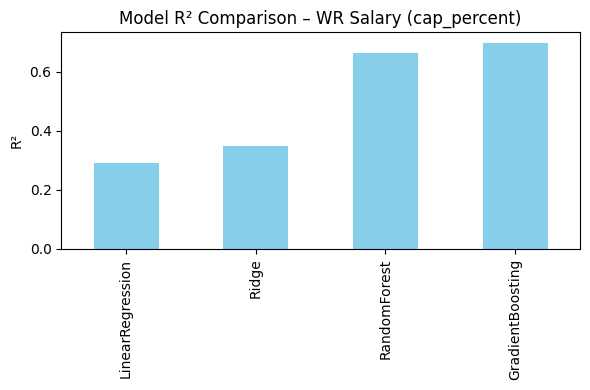

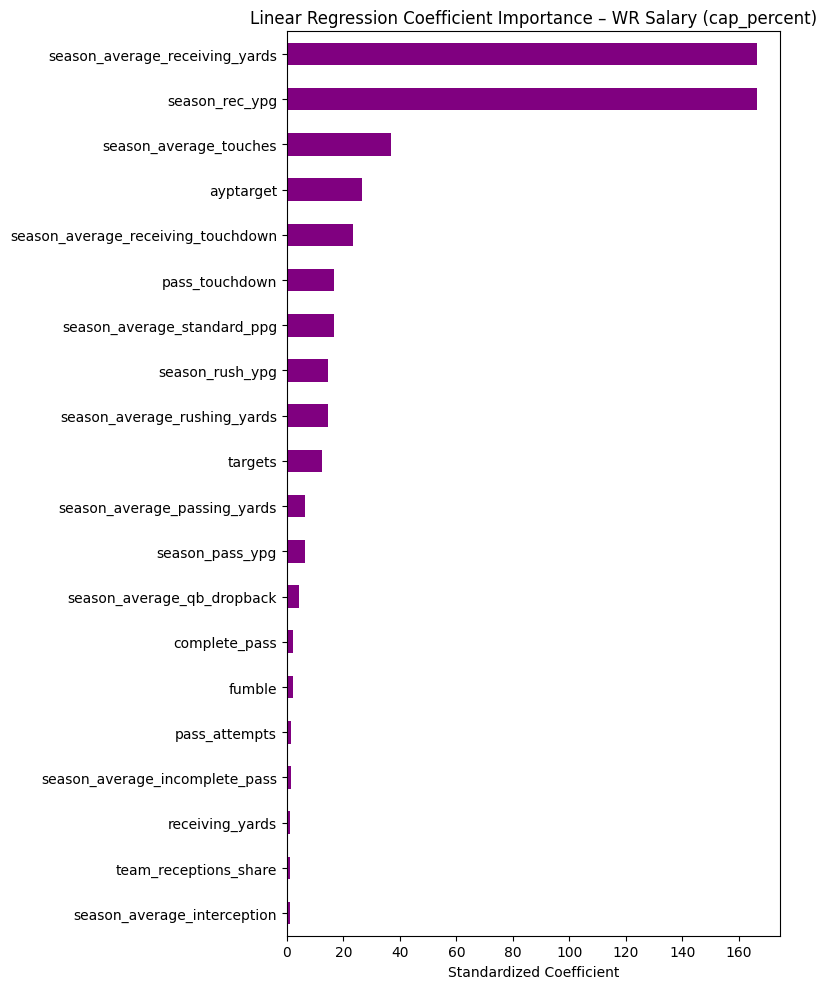

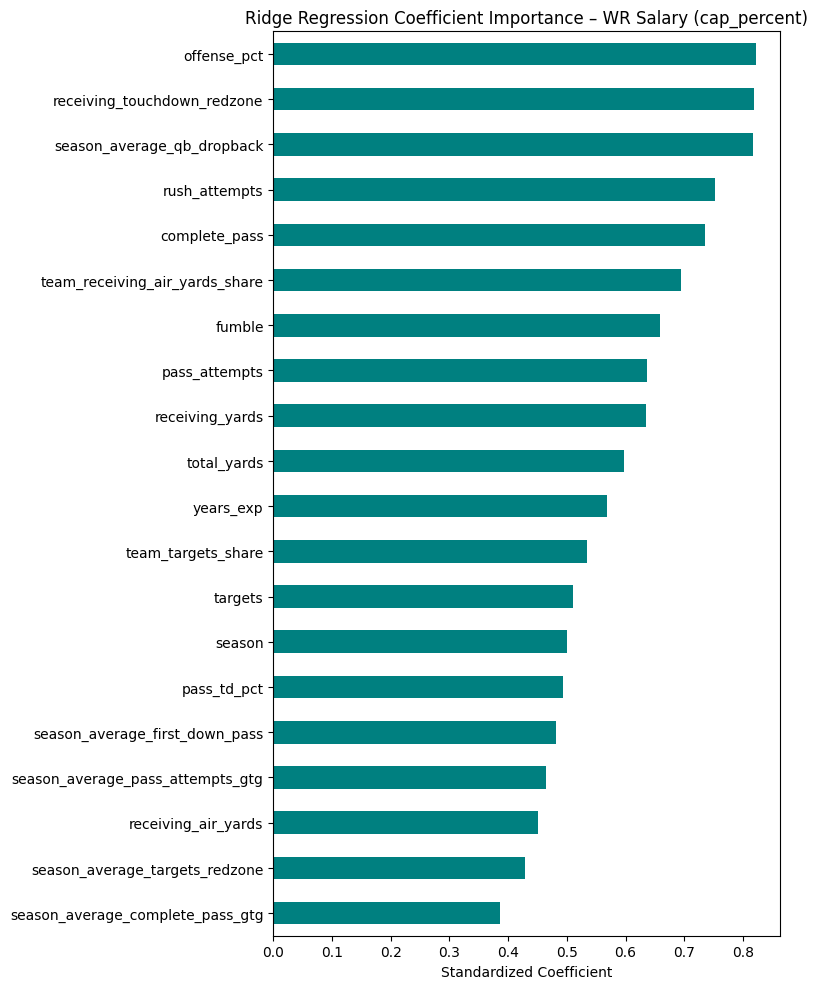

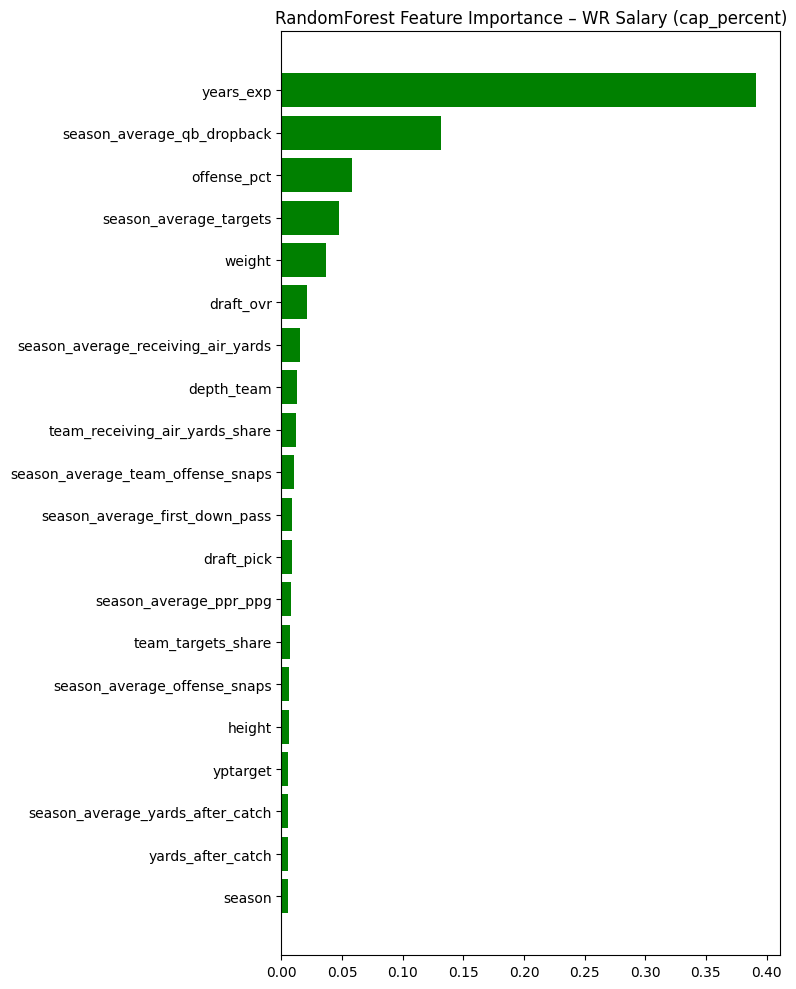

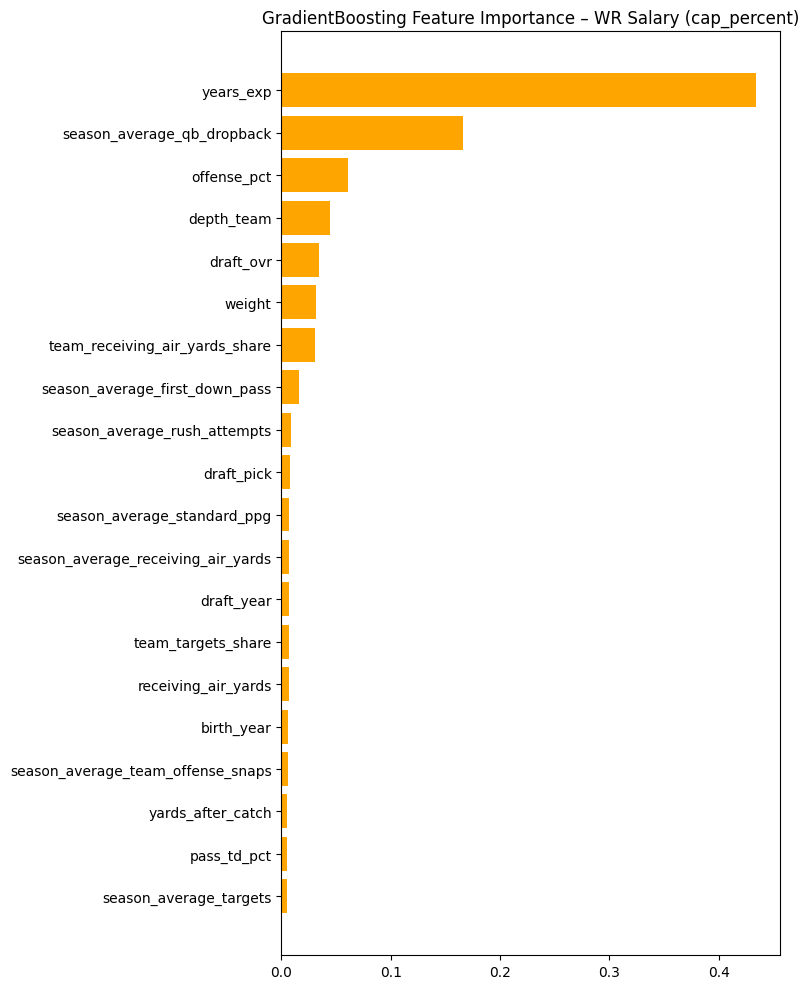

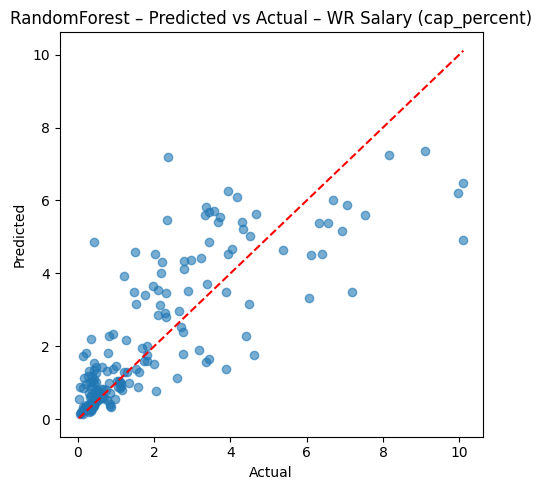

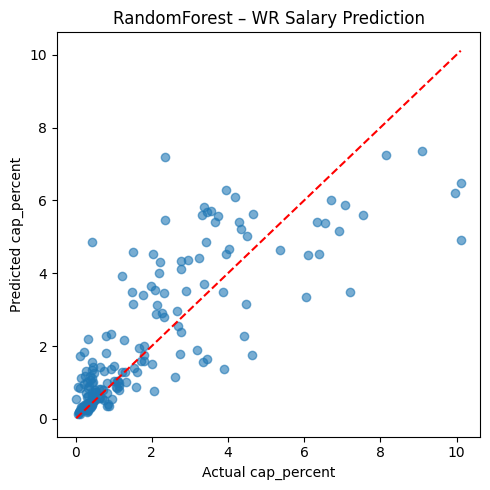

In [12]:
# ===============================================================
# SALARY PREDICTION MODELS FOR QB / RB / WR
# ===============================================================

position_dfs = {
    "QB": QB_df,
    "RB": RB_df,
    "WR": WR_df,
}

salary_results = {}

for pos, df_pos in position_dfs.items():

    # Ensure salary exists
    if "cap_percent" not in df_pos.columns:
        print(f"{pos}: cap_percent not found, skipping.\n")
        continue

    # Restrict to rows that actually HAVE salary information
    df_salary = df_pos[df_pos["cap_percent"].notna()].copy()
    print(f"\n{pos}: {len(df_salary)} players with salary data")

    # Skip if there’s not enough salary data to train a model
    if len(df_salary) < 40:
        print(f"{pos}: Not enough samples to train salary model. Skipping.\n")
        continue

    # Build numeric feature matrix + target vector
    X, y = build_feature_target(df_salary, target_col="cap_percent")

    print(f"\n\n==============================")
    print(f"SALARY MODELS – {pos}")
    print("==============================")

    # Train models + produce graphs + importance
    res_df, rf_preds = run_regression_models(
        X, y,
        title=f"{pos} Salary (cap_percent)"
    )

    salary_results[pos] = res_df

    # Optional: RF predicted vs actual
    if rf_preds is not None:
        y_test, preds = rf_preds
        plt.figure(figsize=(5, 5))
        plt.scatter(y_test, preds, alpha=0.6)
        lims = [
            min(y_test.min(), preds.min()),
            max(y_test.max(), preds.max())
        ]
        plt.plot(lims, lims, "r--")
        plt.xlabel("Actual cap_percent")
        plt.ylabel("Predicted cap_percent")
        plt.title(f"RandomForest – {pos} Salary Prediction")
        plt.tight_layout()
        plt.show()


In [13]:
for pos, df_pos in position_dfs.items():
    print(pos, df_pos.shape, df_pos["cap_percent"].notna().sum())


QB (432, 169) 432
RB (674, 169) 674
WR (1071, 169) 1071


In [14]:
# ============================================================
# NEXT-YEAR TARGET CREATION
# ============================================================

# Start from cleaned offense data
off_next = offense_clean.copy()

# Ensure season is numeric just in case (some CSVs load as object)
off_next["season"] = off_next["season"].astype(int)

# Sort by player and season to ensure correct shift order
off_next = off_next.sort_values(["player_id", "season"])

# Define which base stat predicts NEXT year's performance
next_year_base_targets = {
    "QB": "passer_rating",
    "RB": "rushing_yards",
    "WR": "receiving_yards",
}

# Collect all unique base stats needed
base_stats_needed = set(next_year_base_targets.values())

# Create *_next columns
for stat in base_stats_needed:
    if stat not in off_next.columns:
        print(f"WARNING: '{stat}' not found in offense_clean columns. Skipping next-year target for it.")
        continue

    # shift(-1) gives next year's value for each player
    off_next[f"{stat}_next"] = (
        off_next.groupby("player_id")[stat].shift(-1)
    )

print("\nCreated next-year target columns:")
print([f"{s}_next" for s in base_stats_needed if f"{s}_next" in off_next.columns])

# Show a few rows for sanity
off_next.head(10)



Created next-year target columns:
['rushing_yards_next', 'receiving_yards_next', 'passer_rating_next']


,player_id,player_name,position,birth_year,draft_year,draft_round,draft_pick,draft_ovr,height,weight,...,yptouch,player_name_clean_x,team_name_readable,cap_percent,team_y,player_name_clean_y,team_abbr,rushing_yards_next,receiving_yards_next,passer_rating_next
0,00-0007091,Matt Hasselbeck,QB,1975,1998.0,6.0,34.0,187.0,76.0,235.0,...,5.58,MATT HASSELBECK,Colts,2.81,indianapolis-colts,MATT HASSELBECK,IND,15.0,0.0,85.58
411,00-0007091,Matt Hasselbeck,QB,1975,1998.0,6.0,34.0,187.0,76.0,235.0,...,6.39,MATT HASSELBECK,Colts,1.97,indianapolis-colts,MATT HASSELBECK,IND,NaN,NaN,NaN
1,00-0010346,Peyton Manning,QB,1976,1998.0,1.0,1.0,1.0,77.0,230.0,...,4.59,PEYTON MANNING,Broncos,12.96,denver-broncos,PEYTON MANNING,DEN,-24.0,0.0,104.08
2,00-0010346,Peyton Manning,QB,1976,1998.0,1.0,1.0,1.0,77.0,230.0,...,7.76,PEYTON MANNING,Broncos,12.96,denver-broncos,PEYTON MANNING,DEN,10.0,0.0,76.21
412,00-0010346,Peyton Manning,QB,1976,1998.0,1.0,1.0,1.0,77.0,230.0,...,5.72,PEYTON MANNING,Broncos,12.06,denver-broncos,PEYTON MANNING,DEN,-6.0,0.0,71.47
413,00-0010346,Peyton Manning,QB,1976,1998.0,1.0,1.0,1.0,77.0,230.0,...,7.01,PEYTON MANNING,Broncos,12.06,denver-broncos,PEYTON MANNING,DEN,NaN,NaN,NaN
3,00-0019596,Tom Brady,QB,1977,2000.0,6.0,33.0,199.0,76.0,225.0,...,6.56,TOM BRADY,Patriots,10.64,new-england-patriots,TOM BRADY,NE,57.0,0.0,98.86
4,00-0019596,Tom Brady,QB,1977,2000.0,6.0,33.0,199.0,76.0,225.0,...,6.84,TOM BRADY,Patriots,10.64,new-england-patriots,TOM BRADY,NE,19.0,0.0,78.12
414,00-0019596,Tom Brady,QB,1977,2000.0,6.0,33.0,199.0,76.0,225.0,...,6.01,TOM BRADY,Patriots,9.68,new-england-patriots,TOM BRADY,NE,53.0,36.0,103.31
415,00-0019596,Tom Brady,QB,1977,2000.0,6.0,33.0,199.0,76.0,225.0,...,7.45,TOM BRADY,Patriots,9.68,new-england-patriots,TOM BRADY,NE,13.0,0.0,99.72




NEXT-YEAR MODELS – QB (target: passer_rating_next)

=== Regression Results: QB Next-Year passer_rating ===


,R2,RMSE,MAE
LinearRegression,-407.057348,633.244446,210.006868
Ridge,-4.514808,73.616637,46.290145
RandomForest,0.156234,28.795310,20.488408
GradientBoosting,-0.082603,32.617110,23.706429


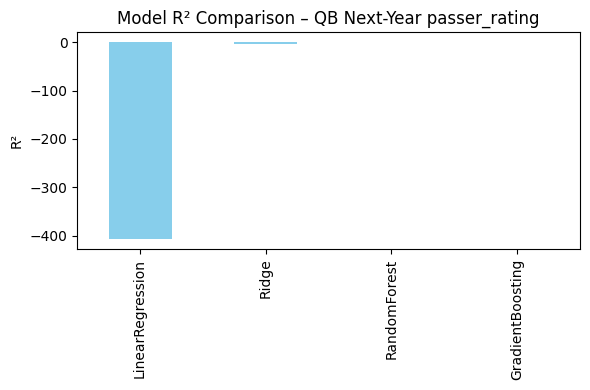

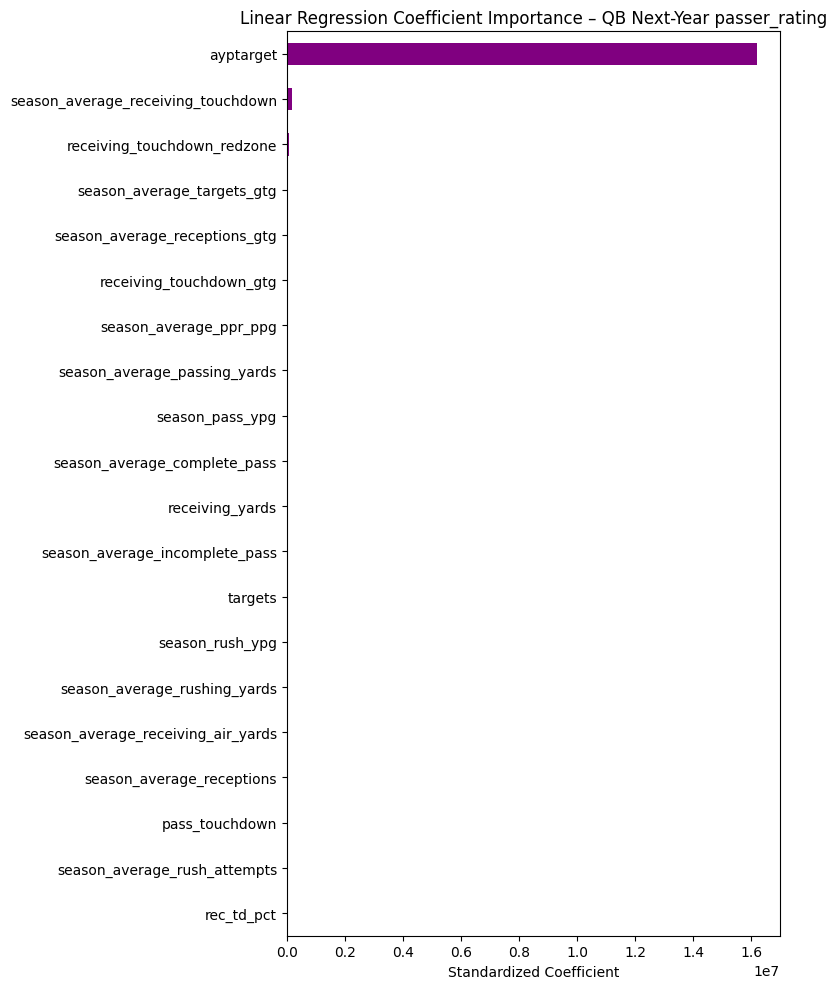

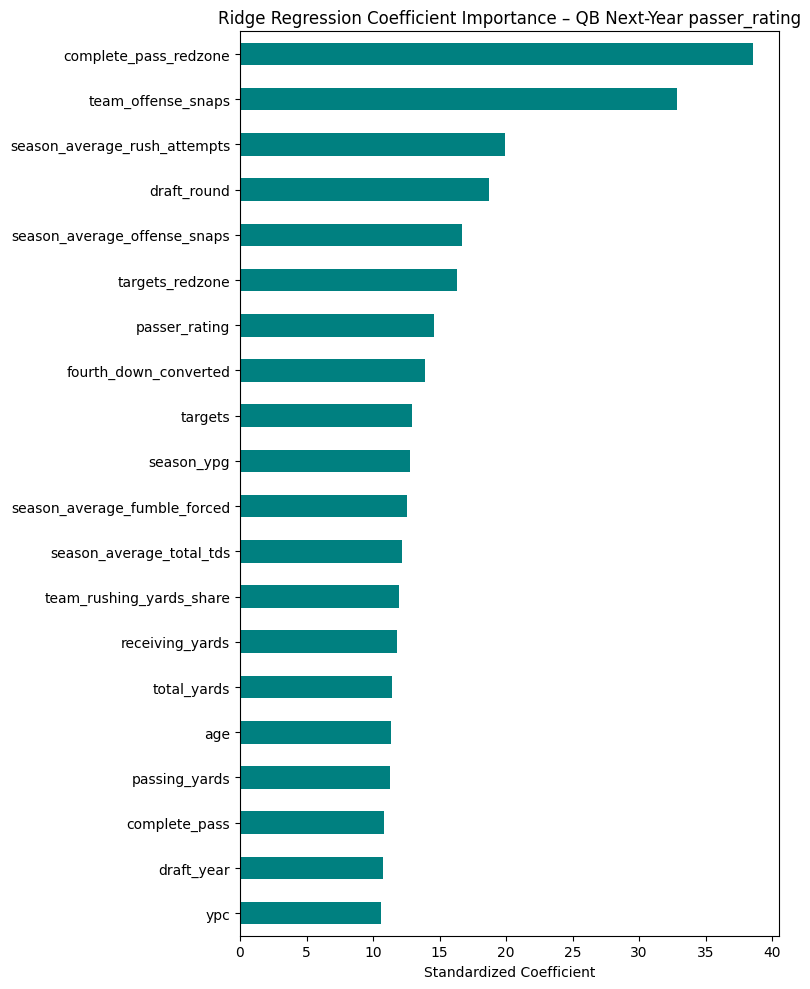

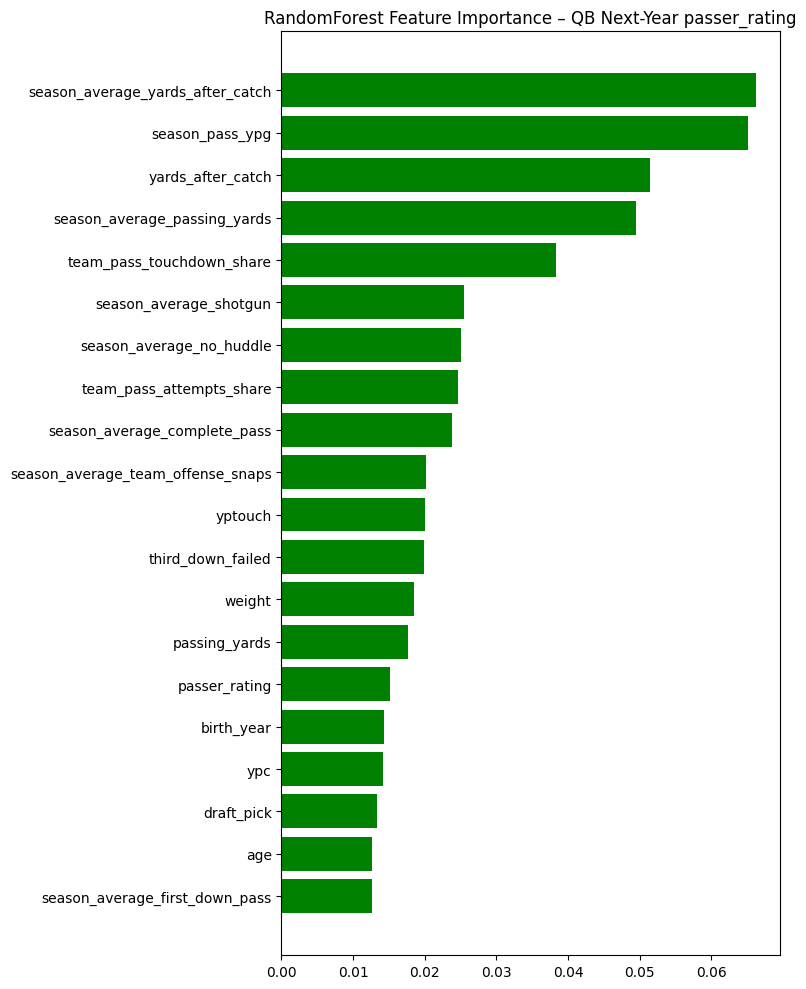

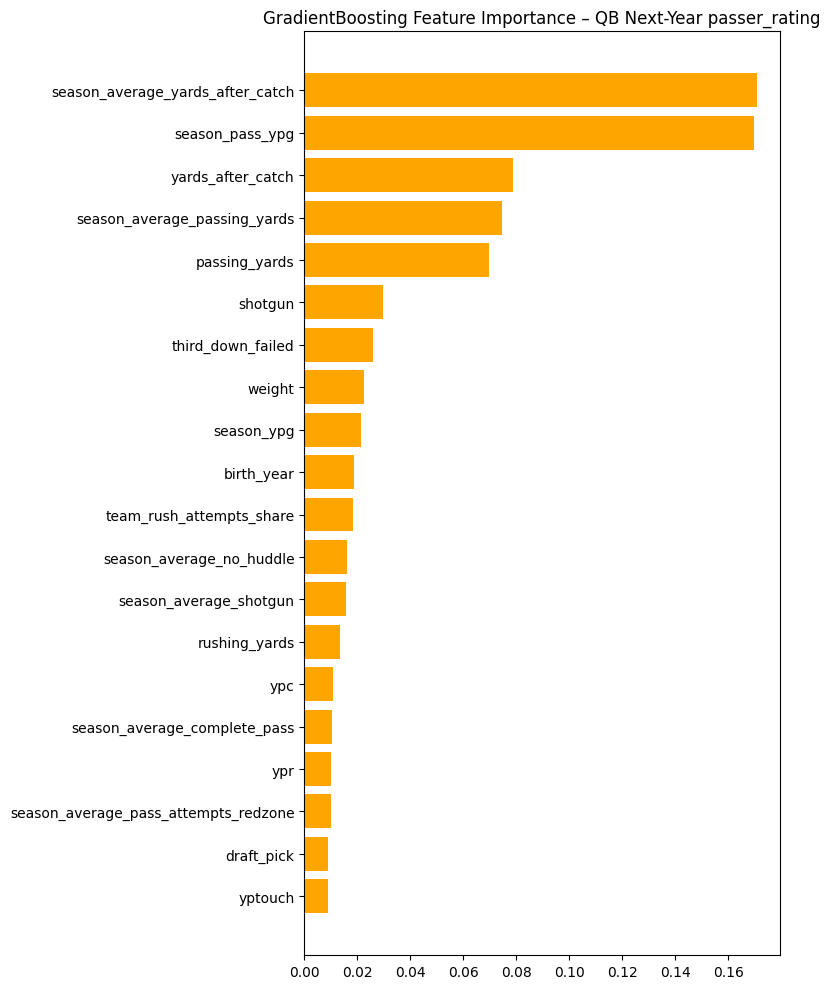

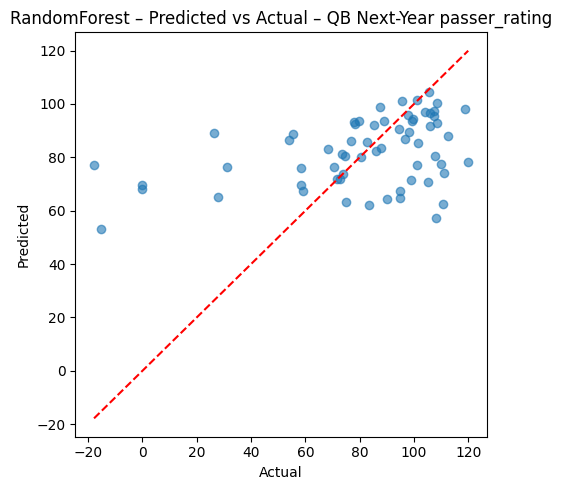

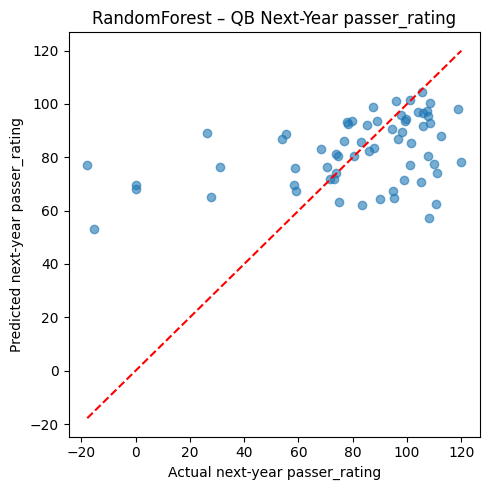



NEXT-YEAR MODELS – RB (target: rushing_yards_next)

=== Regression Results: RB Next-Year rushing_yards ===


,R2,RMSE,MAE
LinearRegression,-1.818421,560.733960,370.321993
Ridge,-0.563861,417.688947,308.107392
RandomForest,0.001673,333.726284,273.421703
GradientBoosting,-0.122792,353.918665,278.799426


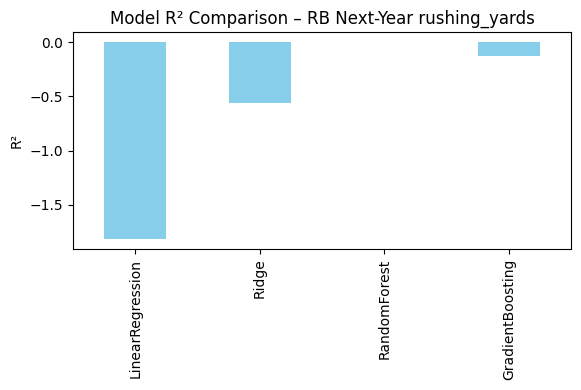

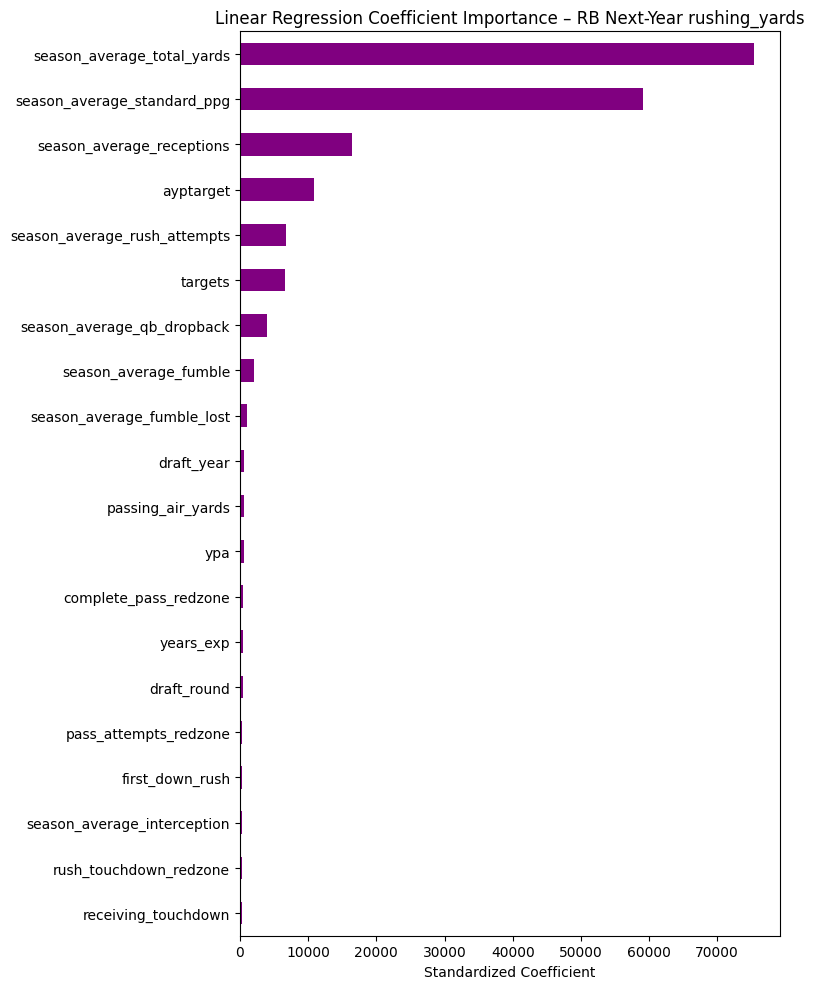

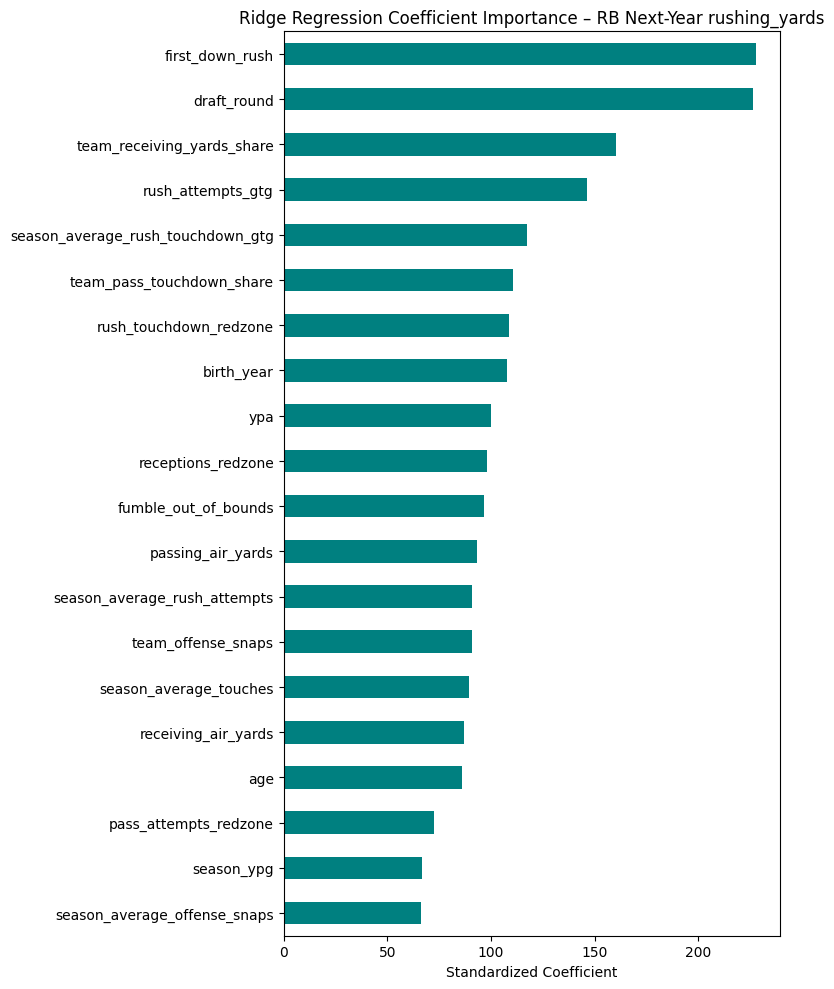

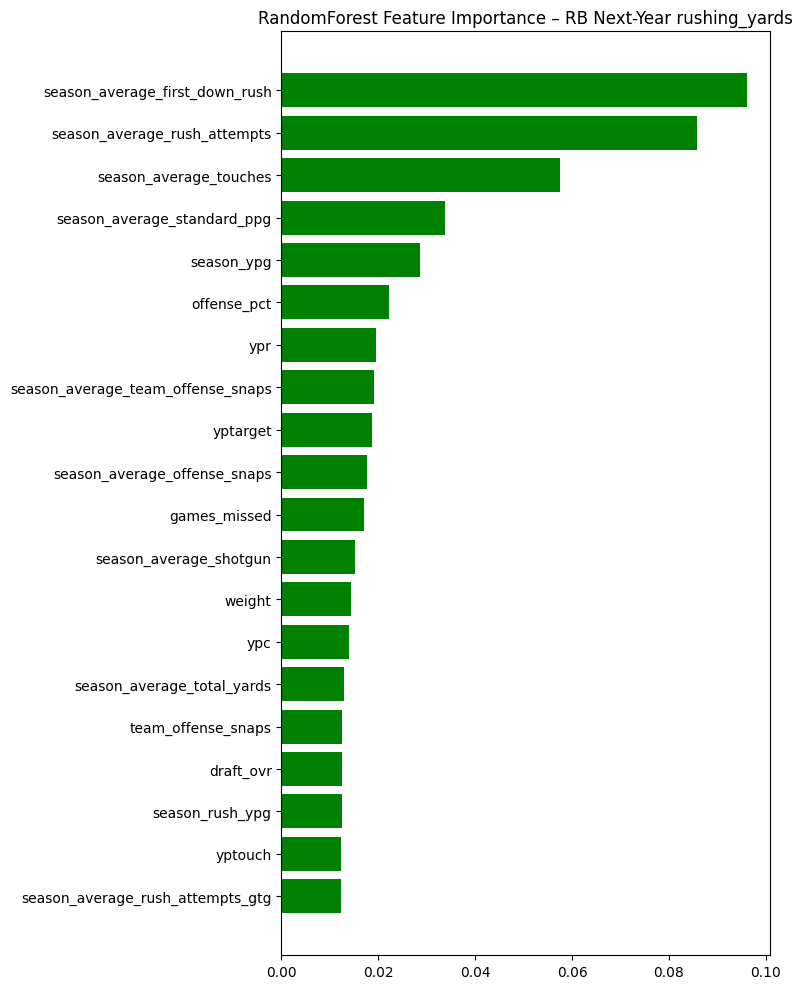

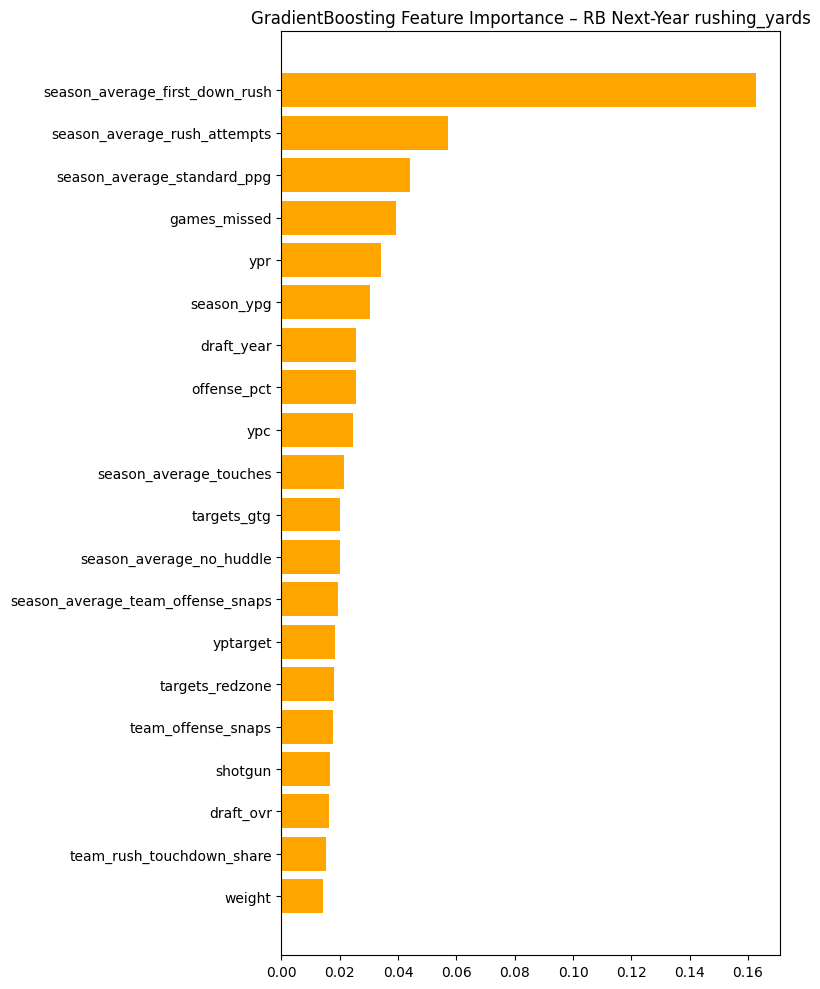

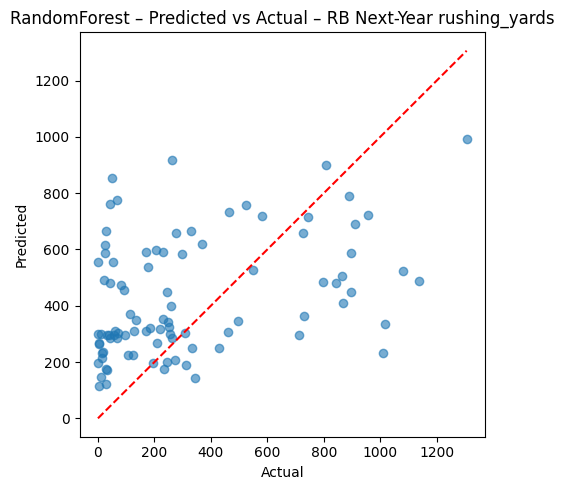

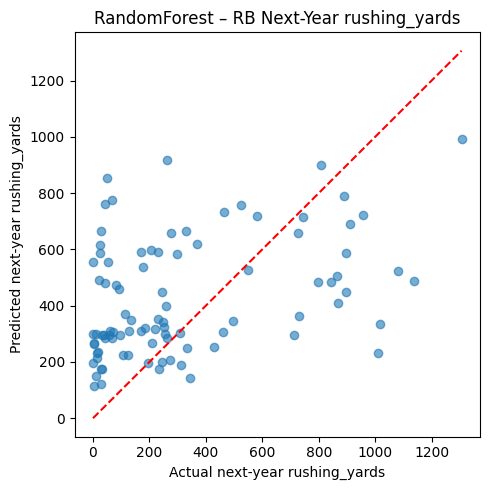



NEXT-YEAR MODELS – WR (target: receiving_yards_next)

=== Regression Results: WR Next-Year receiving_yards ===


,R2,RMSE,MAE
LinearRegression,-10.817339,1324.275358,465.962432
Ridge,-0.398910,455.631139,337.202471
RandomForest,0.214678,341.383263,273.236644
GradientBoosting,0.196060,345.406259,264.988358


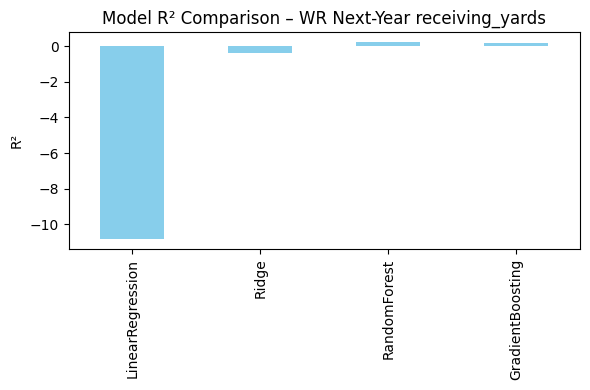

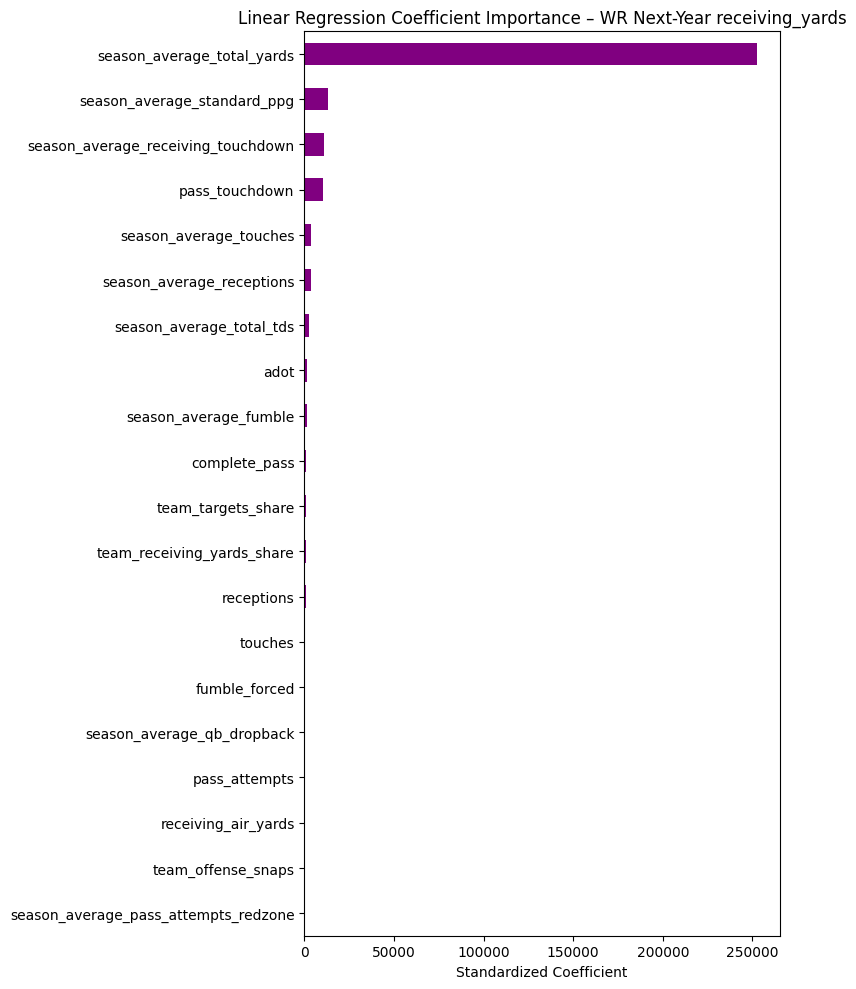

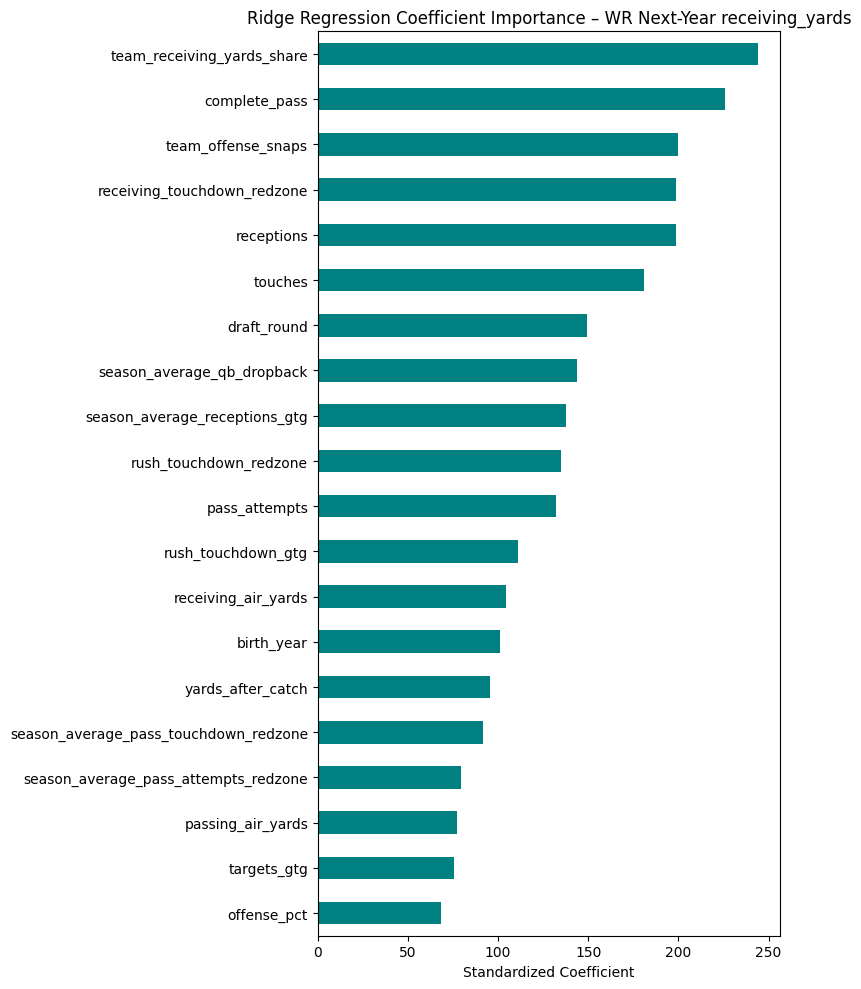

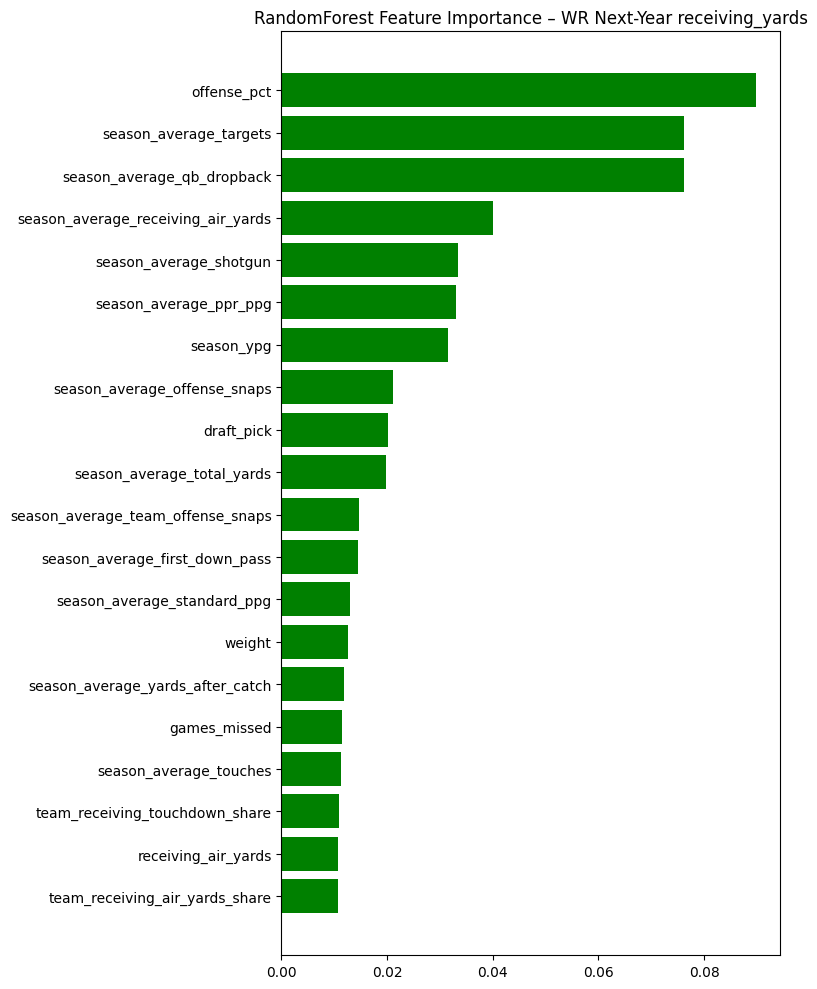

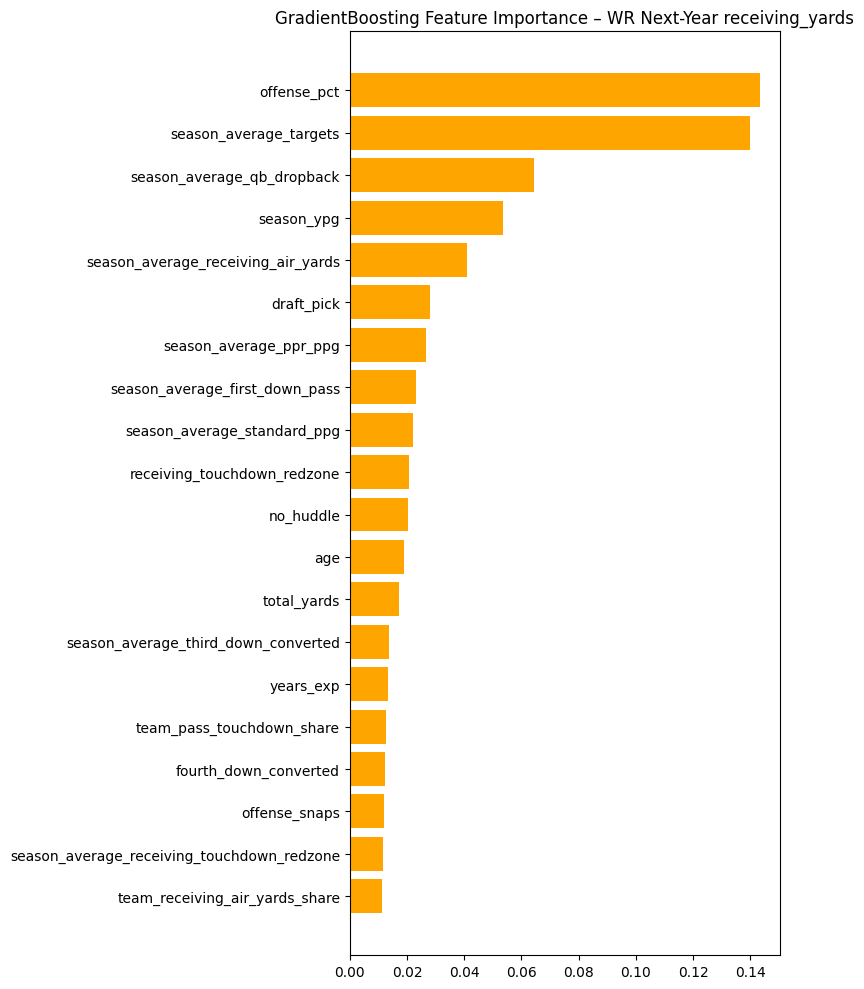

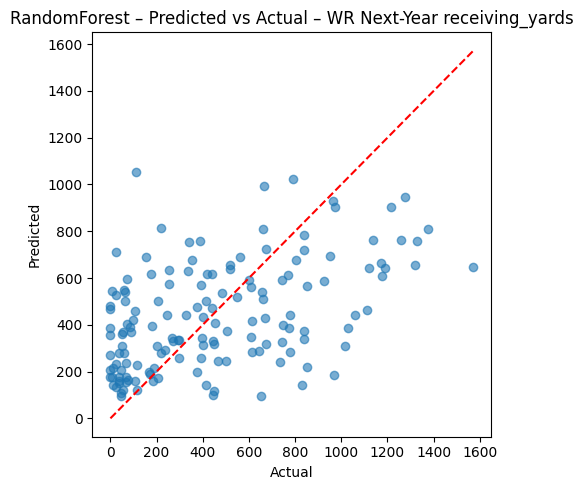

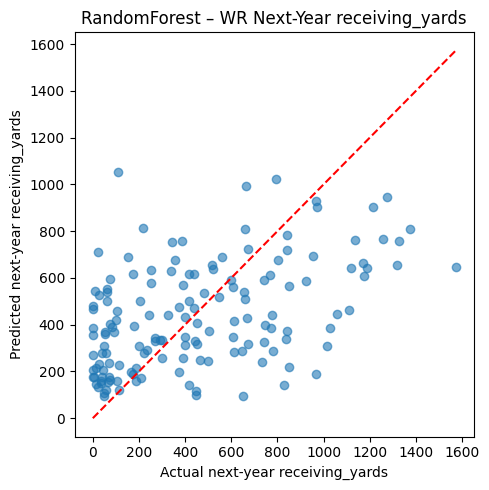

In [15]:
# ================================================================
# NEXT-YEAR PREDICTION MODELS (Leakage-Safe)
# ================================================================

next_year_results = {}

for pos, base_stat in next_year_base_targets.items():
    df_pos = off_next[off_next["position"] == pos].copy()
    target_col = f"{base_stat}_next"

    if target_col not in df_pos.columns:
        print(f"{pos}: {target_col} not found, skipping.")
        continue

    # Keep only rows where we *have* next-season stats
    df_pos = df_pos[df_pos[target_col].notna()].copy()
    if df_pos.empty:
        print(f"{pos}: no rows with next-year target, skipping.")
        continue

    # -----------------------------------------------------------
    # Drop all *_next columns EXCEPT the target (prevents leakage)
    # -----------------------------------------------------------
    next_cols = [
        c for c in df_pos.columns
        if c.endswith("_next") and c != target_col
    ]

    # Also remove salary from next-year models
    extra_drop = ["cap_percent"] + next_cols

    # Build feature matrix X and target y
    X, y = build_feature_target(
        df_pos,
        target_col=target_col,
        extra_drop=extra_drop
    )

    print(f"\n\n==============================")
    print(f"NEXT-YEAR MODELS – {pos} (target: {target_col})")
    print("==============================")

    # Run full regression suite (Linear, Ridge, GB, RF)
    res_df, model_outputs = run_regression_models(
        X, y,
        title=f"{pos} Next-Year {base_stat}"
    )

    next_year_results[pos] = res_df

    # -----------------------------------------------------------
    # RandomForest predicted vs actual plot
    # -----------------------------------------------------------
    if model_outputs["rf"] is not None:
        model, y_test, preds = model_outputs["rf"]

        plt.figure(figsize=(5, 5))
        plt.scatter(y_test, preds, alpha=0.6)
        lims = [
            min(y_test.min(), preds.min()),
            max(y_test.max(), preds.max())
        ]
        plt.plot(lims, lims, "r--")
        plt.xlabel(f"Actual next-year {base_stat}")
        plt.ylabel(f"Predicted next-year {base_stat}")
        plt.title(f"RandomForest – {pos} Next-Year {base_stat}")
        plt.tight_layout()
        plt.show()


In [18]:
# ============================================================
# SALARY MODEL SUMMARY
# ============================================================

salary_summary_rows = []

for pos, res_df in salary_results.items():
    for model_name, row in res_df.iterrows():
        salary_summary_rows.append({
            "Position": pos,
            "Model": model_name,
            "Task": "Salary (cap_percent)",
            "R2": row["R2"],
            "RMSE": row["RMSE"],
            "MAE": row["MAE"],
        })

salary_summary = pd.DataFrame(salary_summary_rows)
print("\n=== SALARY MODEL SUMMARY ===")
display(salary_summary)


# ============================================================
# NEXT-YEAR PREDICTION SUMMARY
# ============================================================

next_year_summary_rows = []

for pos, res_df in next_year_results.items():
    for model_name, row in res_df.iterrows():
        next_year_summary_rows.append({
            "Position": pos,
            "Model": model_name,
            "Task": "Next-Year Stat",
            "R2": row["R2"],
            "RMSE": row["RMSE"],
            "MAE": row["MAE"],
        })

next_year_summary = pd.DataFrame(next_year_summary_rows)
print("\n=== NEXT-YEAR PREDICTION SUMMARY ===")
display(next_year_summary)



=== SALARY MODEL SUMMARY ===


,Position,Model,Task,R2,RMSE,MAE
0,QB,LinearRegression,Salary (cap_percent),-1.297310e+00,6.994667,4.275874
1,QB,Ridge,Salary (cap_percent),2.928954e-01,3.880602,3.083620
2,QB,RandomForest,Salary (cap_percent),7.341424e-01,2.379478,1.566467
3,QB,GradientBoosting,Salary (cap_percent),7.139219e-01,2.468309,1.572505
4,RB,LinearRegression,Salary (cap_percent),-1.413380e+09,56369.861031,5342.303925
5,RB,Ridge,Salary (cap_percent),3.085781e-01,1.246778,0.777676
6,RB,RandomForest,Salary (cap_percent),6.205763e-01,0.923591,0.464674
7,RB,GradientBoosting,Salary (cap_percent),6.290863e-01,0.913175,0.485299
8,WR,LinearRegression,Salary (cap_percent),2.905203e-01,1.748743,1.250733
9,WR,Ridge,Salary (cap_percent),3.497671e-01,1.674135,1.204110



=== NEXT-YEAR PREDICTION SUMMARY ===


,Position,Model,Task,R2,RMSE,MAE
0,QB,LinearRegression,Next-Year Stat,-407.057348,633.244446,210.006868
1,QB,Ridge,Next-Year Stat,-4.514808,73.616637,46.290145
2,QB,RandomForest,Next-Year Stat,0.156234,28.795310,20.488408
3,QB,GradientBoosting,Next-Year Stat,-0.082603,32.617110,23.706429
4,RB,LinearRegression,Next-Year Stat,-1.818421,560.733960,370.321993
5,RB,Ridge,Next-Year Stat,-0.563861,417.688947,308.107392
6,RB,RandomForest,Next-Year Stat,0.001673,333.726284,273.421703
7,RB,GradientBoosting,Next-Year Stat,-0.122792,353.918665,278.799426
8,WR,LinearRegression,Next-Year Stat,-10.817339,1324.275358,465.962432
9,WR,Ridge,Next-Year Stat,-0.398910,455.631139,337.202471


In [17]:
salary_summary.to_csv("salary_model_summary_by_position.csv", index=False)
next_year_summary.to_csv("next_year_model_summary_by_position.csv", index=False)
